# Simple Reinforcement Learning with Tensorflow: Part 0 - Q-Networks
In this iPython notebook we implement a Q-Network algorithm that solves the FrozenLake problem. To learn more, read here: https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

For more reinforcment learning tutorials, see:
https://github.com/awjuliani/DeepRL-Agents

In [1]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\atul.dhingra\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load the environment

In [2]:
env = gym.make('FrozenLake-v0')

## The Q-Network Approach

### Implementing the network itself

In [3]:
tf.reset_default_graph()

In [4]:
#These lines establish the feed-forward part of the network used to choose actions
# State is fed as a one hot encoded vector (1, 16) -- 16 possible values(4x4 grid)
input_size = 16
# 4 values corresponding to each action(U, D, L, R)
output_size = 4

X = tf.placeholder(shape=[1, input_size], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([input_size, output_size], 0, 0.01))

Qout = tf.matmul(X, W)
predict = tf.argmax(Qout, 1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1, output_size], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

### Training the network

In [5]:
init = tf.global_variables_initializer()
tf.set_random_seed(1234)

# Set learning parameters
gamma = .99
e = 0.1
num_episodes = 2000
max_steps = 100
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        done = False
        #The Q-Network
        for j in range(max_steps):
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a, allQ = sess.run([predict, Qout], feed_dict={X:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:  # Less than e -- less randomness, choose from action space
                a[0] = env.action_space.sample()
            #Get new state and reward from environment
            s1, r, done, _ = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={X:np.identity(16)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + gamma*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={X:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if done == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of succesful episodes: 0.4465%


### Some statistics on network performance

We can see that the network beings to consistly reach the goal around the 750 episode mark.

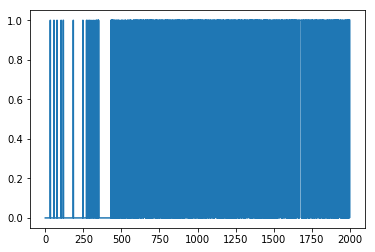

In [6]:
plt.plot(rList)

It also begins to progress through the environment for longer than chance aroudn the 750 mark as well.

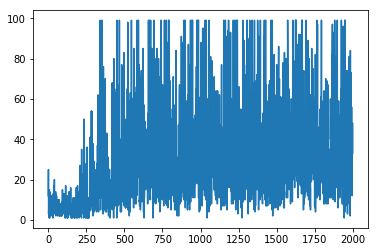

In [7]:
plt.plot(jList)